# Librairies à importer

In [133]:
import pandas as pd
#import ydata_profiling
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from correlationinspector import analyze_multiple_correlations as amc
from correlationinspector import desequilibre_outliers as do
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering



# Préparation des données

## Néttoyage de la base

In [3]:
data = pd.read_csv('base_excel/data_typologie.csv')

data.info() et data.describe() pour avoir un appercu des données. 

résultat
Je constate que certaines variables sont de type object. Il faudra que je vois attentivement ces variables:
name
album_name
artists
key
mode
langue1


In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18093 entries, 0 to 18092
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   18093 non-null  object 
 1   name                 18093 non-null  object 
 2   album_name           7313 non-null   object 
 3   artists              18093 non-null  object 
 4   danceability         18093 non-null  float64
 5   energy               18093 non-null  float64
 6   key                  18093 non-null  object 
 7   loudness             18093 non-null  float64
 8   mode                 18093 non-null  object 
 9   speechiness          18093 non-null  float64
 10  acousticness         18093 non-null  float64
 11  instrumentalness     18093 non-null  float64
 12  liveness             18093 non-null  float64
 13  valence              18093 non-null  float64
 14  tempo                18093 non-null  float64
 15  duration_ms          18093 non-null 

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,pourcentage_langue1,langue2,pourcentage_langue2,langue3,pourcentage_langue3,release_year
count,18093.000000,18093.000000,18093.000000,18093.000000,18093.000000,18093.000000,18093.000000,18093.000000,18093.000000,1.809300e+04,18093.0,0.0,0.0,0.0,0.0,18093.000000
mean,0.587941,0.590912,-8.587721,0.098994,0.393269,0.047911,0.227448,0.507528,119.072954,2.241003e+05,100.0,NaN,NaN,NaN,NaN,2007.506992
std,0.168894,0.225150,3.803973,0.113238,0.317634,0.163591,0.222126,0.247557,28.308460,7.548066e+04,0.0,NaN,NaN,NaN,NaN,28.774494
min,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.309300e+04,100.0,NaN,NaN,NaN,NaN,0.000000
25%,0.475000,0.431000,-10.454000,0.034500,0.092700,0.000000,0.098300,0.306000,96.992000,1.815730e+05,100.0,NaN,NaN,NaN,NaN,2003.000000
50%,0.599000,0.613000,-7.788000,0.049000,0.330000,0.000007,0.129000,0.506000,118.021000,2.145330e+05,100.0,NaN,NaN,NaN,NaN,2009.000000
75%,0.715000,0.767000,-5.986000,0.106000,0.679000,0.001040,0.270000,0.706000,135.947000,2.533470e+05,100.0,NaN,NaN,NaN,NaN,2017.000000
max,0.991000,1.000000,4.584000,0.947000,0.996000,0.982000,1.000000,0.999000,215.149000,1.576693e+06,100.0,NaN,NaN,NaN,NaN,2023.000000


l'objectif est de faire une typologie des type des chansons en fonction des caractéristiques et de voir l'évolution des caégorie dans le temps. La première étape a été de voir s'il y a suffisament de données par années. 

résultat
le tableau de fréquence de l'année de sorties des chansons a montré qu'il y a des années qui avaient très peu de chansons :une chanson, deux chansons etc. alors j'ai pensé voir l'évoltion par décénie afin de ne pas perdre les données. Les chercheurs choisissent souvent d'analyser la musique par décennie en raison de changements culturels et technologiques significatifs, facilitant l'observation des évolutions des genres et des styles. Chaque décennie reflète des préoccupations sociétales spécifiques, tandis que les données sur les ventes et les classements sont souvent disponibles à cette échelle. Cela permet également d'identifier des cycles musicaux et des phénomènes de mode récurrents.


In [5]:
data['decenie'] = (data['release_year'] // 10) *10

### Compter les fréquences par décennie
frequency_by_year = data['release_year'].value_counts().sort_index()

frequency_by_decade = data['decenie'].value_counts().sort_index()

### Afficher les résultats
print(frequency_by_year)
print(frequency_by_decade)
#data = data[data['decenie'] >1950]

release_year
0.0         3
1921.0      2
1922.0      4
1924.0      2
1925.0      2
         ... 
2019.0    959
2020.0    828
2021.0    489
2022.0    468
2023.0    262
Name: count, Length: 93, dtype: int64
decenie
0.0          3
1920.0      26
1930.0      73
1940.0      23
1950.0      82
1960.0     271
1970.0     186
1980.0     350
1990.0    1220
2000.0    6949
2010.0    6863
2020.0    2047
Name: count, dtype: int64


La répartition par décénies montre que les décénie 1920 et 1940 sont très faiblement représentées. les décénies 30 et 50 sont faiblement représenté au regard de la taille de l'échantillon. J'ai fixé un seuil de 100 chansons par décennie est justifié scientifiquement par des considérations de puissance statistique, de stabilité des estimations, de représentativité, de comparabilité, de simplicité méthodologique, et d'alignement avec les normes de recherche.
L'objectif global du projet m'a contraint à limiter la durée des chansons en ms dans l'interval 73897.375 et 361032.375
j'ai supprimer aussi les individus au regard de : 
Une valeur de "liveness" supérieure à 0,8 indique une forte probabilité que le morceau soit joué en direct. ce qui peut biaiser la typologie
Une valeur de instrumentalness supérieure à 0,5 indique une forte probabilité que le morceau soit un instrumentale
Une valeur de speechiness supérieure à 0,66 indique une forte probabilité que le morceau soit  constituées entièrement de mots parlés (talk-show, livre audio, poésie)


In [6]:
## suppression des lignes 
data = data[data['decenie'] >= 1950] #où l'années est inférieur à 1960
data = data[(data['duration_ms'] >= 73897.375) & (data['duration_ms'] <= 361032.375)]
data = data[(data['liveness'] <= 0.8)] # Une valeur supérieure à 0,8 indique une forte probabilité que le morceau soit joué en direct.
data = data[(data['instrumentalness'] <= 0.5)] # Une valeur supérieure à 0,5 indique une forte probabilité que le morceau soit un instrumentale
data = data[(data['speechiness'] <= 0.66)] # Une valeur supérieure à 0,66 indique une forte probabilité que le morceau soit  constituées entièrement de mots parlés (talk-show, livre audio, poésie)


AU regard des objectifs de l'étude et de la description des variables, certaines variables ne me seront pas utiles. donc je l'ai supprime

In [7]:
## Suppression des variables
variables_a_supprimer = ['pourcentage_langue3', 'langue3', 'pourcentage_langue2', 'langue2', 'langue1', 'pourcentage_langue1', 'album_name', 'artists', 'name']
data = data.drop(columns=variables_a_supprimer, errors='ignore')

Dans la liste des variables de type object, il ne reste plus que key et mode. Je vais voir les modalités de ces variables et mieux comprendre leur nature et ce que je peux faire


In [8]:
obtenir_modalite=['mode', 'key']
for var in obtenir_modalite:
    modalites_uniques = data[var].unique()
    print(f'les modalité de la variable {var} sont {modalites_uniques}')

les modalité de la variable mode sont ['1' '0' '0.0' 'Minor' '1.0' 'Major']
les modalité de la variable key sont ['7' '11' '2' '5' '10.0' '1.0' '0' '1' '4' '9' 'B' '2.0' '11.0' '10' '6'
 '3.0' '0.0' '6.0' 'D' 'F' '5.0' 'F#' '8' '8.0' '3' '7.0' '4.0' 'C' 'G#'
 'A' 'E' 'G' 'D#' 'A#' 'C#' '9.0']


Pour plus de détails, je veux voir la distribution de ces variables

In [9]:
frequence_mode = data['mode'].value_counts()
print(frequence_mode)

mode
1        6697
0        5328
0.0      1228
1.0      1174
Major     831
Minor     370
Name: count, dtype: int64


In [10]:
frequence_key = data['key'].value_counts()
print(frequence_key)


key
7       1512
0       1436
9       1317
2       1296
4       1050
5       1002
1        969
11       931
6        734
10       729
8        663
3        386
0.0      298
7.0      257
9.0      231
1.0      224
2.0      204
11.0     198
4.0      192
5.0      186
C        183
10.0     180
8.0      177
6.0      167
D        163
A        119
G        115
F         94
C#        93
A#        90
3.0       88
B         88
E         85
G#        70
D#        51
F#        50
Name: count, dtype: int64


la distribution des variables mon permis de voir les modifications que je peux faire; D'abord, avec mode, je vais devoir labéliser et recodifier parce que la description de la base dit qu'il y a 2 modalités : minor qui correspond à '0' et '0.0' et major qui correspond à '1' et '1.0'. 
Il en est de même pour la variable key qui doit être codifié. Toutefois, pour keys, je constate que ces une variable cyclique, je vais donc faire une transformation plutard Dans la section transformation. j'ai donc noté sur un marckdown pour me le rappeler l'étapes des transformation. Je préfère automatiser les actions. Cela permet de gagner du temps de limiter les erreurs et de rappidement update. J'ai donc écrit une fonction que fais la codification et prend entré, la valeur et la bibliothèque

In [11]:
# Dictionnaires de mapping
def convert(value, mapping):
    try:
        # Convertir les valeurs décimales en entiers
        if isinstance(value, str) and '.' in value:
            value = int(float(value))
        # Convertir les notes musicales en entiers
        return int(mapping.get(value, value))  # Retourner la valeur originale si elle n'est pas trouvée dans le dictionnaire
    except ValueError:
        # Si la conversion échoue, retourner la valeur originale
        return value

note_to_int = {
    'C': 0, 'C#': 1, 'Db': 1, 'D': 2, 'D#': 3, 'Eb': 3,
    'E': 4, 'F': 5, 'F#': 6, 'Gb': 6, 'G': 7, 'G#': 8, 'Ab': 8,
    'A': 9, 'A#': 10, 'Bb': 10, 'B': 11
}

mode_to_int = {
    'Minor': 0, 'Major': 1
}
# Appliquer la conversion
data['key'] = data['key'].apply(lambda x: convert(x, note_to_int))
data['mode'] = data['mode'].apply(lambda x: convert(x, mode_to_int))

j'ai repris la détectiond es modalité pour être sur que la codification a marché

In [12]:
obtenir_modalite=['key','mode']
for var in obtenir_modalite:
    modalites_uniques = data[var].unique()
    print(f'les modalité de la variable {var} sont {modalites_uniques}')

les modalité de la variable key sont [ 7 11  2  5 10  1  0  4  9  6  3  8]
les modalité de la variable mode sont [1 0]


j'ai repris la distribution des variables pour mieux apprécier après codification. EN effet, certaines modalités dans la base de départ ont été recodifiées. 

In [13]:
frequence_key = data['key'].value_counts()
frequence_mode = data['mode'].value_counts()
print(frequence_key)
print(frequence_mode)

key
0     1917
7     1884
9     1667
2     1663
4     1327
1     1286
5     1282
11    1217
10     999
6      951
8      910
3      525
Name: count, dtype: int64
mode
1    8702
0    6926
Name: count, dtype: int64


## Exploration de la data

### Rapport pandas profiling

j'utilise ProfileReport pour explorer les données. Mais je trouve que la fonction est limité et ne m'offre pas suffisament d'outils. Principalement, quand je l'utilise, je regarde la distribution des variables (normal, quadratique, etc...), la présence des outliers, etc...
Je profite pour souligner que j'ai écrit un package qui me permet d'explorer la correlation, les déséquilibre, les outlers, et m'offre plus d'outils pour prendre des décisions. Nous allons l'utilser dans cette description.

In [14]:
profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_file("rapport.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

dd=data['release_year'].value_counts().sort_values()
print(dd)

### Statistiques descriptives

#### Fonction pour identifier les outliers selon la méthode IQR


In [15]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
    return is_outlier

#### Fonction pour compter le nombre d'outliers par individu

In [16]:
def count_outliers(df, variables_to_check):
    # Initialiser une série qui va compter les outliers pour chaque individu
    outliers_count = pd.Series(0, index=df.index)
    
    # Parcourir les colonnes et appliquer la fonction des outliers
    for var in variables_to_check:
        outliers_count += detect_outliers_iqr(df, var).astype(int)
    
    # Retourner le nombre d'outliers par individu
    return outliers_count

#### Fonction pour générer les statistiques descriptives (avec nombre d'outliers par variable)


In [17]:
# Fonction pour analyser les variables numériques
def analyze_numerical_vars(df, numeric_cols):
    # Initialiser un DataFrame pour stocker les statistiques
    stats = pd.DataFrame(index=numeric_cols, columns=[
        'Nombre d\'Outliers', 'Coefficient de Variation', 'Variance', 
        'Moyenne', 'Médiane', 'Type de Distribution', 'Asymétrie', 
        'Minimum', 'Maximum'
    ])
    
    for col in numeric_cols:
        # Calcul des statistiques de base
        mean = df[col].mean()
        std = df[col].std()  # Écart-type
        variance = df[col].var()
        median = df[col].median()
        skewness = df[col].skew()
        min_val = df[col].min()
        max_val = df[col].max()
        
        # Calcul du coefficient de variation (CV = écart-type / moyenne)
        # Si la moyenne est proche de zéro, le CV sera très élevé, il faut vérifier ça
        cv = std / mean if mean != 0 else np.nan
        
        # Détection des outliers via la fonction IQR
        is_outlier = detect_outliers_iqr(df, col)
        
        # Stocker les statistiques dans le DataFrame
        stats.loc[col, 'Nombre d\'Outliers'] = is_outlier.sum()
        stats.loc[col, 'Coefficient de Variation'] = cv
        stats.loc[col, 'Variance'] = variance
        stats.loc[col, 'Moyenne'] = mean
        stats.loc[col, 'Médiane'] = median
        stats.loc[col, 'Type de Distribution'] = 'Normale' if np.abs(skewness) < 0.5 else 'Non Normale'
        stats.loc[col, 'Asymétrie'] = skewness
        stats.loc[col, 'Minimum'] = min_val
        stats.loc[col, 'Maximum'] = max_val

    return stats


#### Fonction pour afficher le tableau de fréquence

In [18]:
def frequency_table(df, col):
    col_values = df[col]
    # Créer des intervalles
    bins = np.linspace(col_values.min(), col_values.max(), 51)  # 50 intervalles
    freq, edges = np.histogram(col_values, bins=bins)
    
    # Créer un DataFrame pour la fréquence
    freq_table = pd.DataFrame({
        'Intervalle': [f'({edges[i]:.2f}, {edges[i+1]:.2f}]' for i in range(len(edges)-1)],
        'Fréquence': freq
    })
    return freq_table

#### Stat descriptive

certes le panda profiling offre une vue d'ensembles,, mais je préfère dévelloper mes propres outils pour explorer les données. Ci-dessus les fonctions qui m'ont permis d'avoir ces statistiques. Ci dessous le code utilisé. je précise que variables_to_use1 inclu toutes les variables numéric y compris booléenne et catégoriel (recodifié). Par la suite, je vais appliquer les méthodes adaptée pour ces deux variables.

In [20]:
variables_to_use1 = data.select_dtypes(include=[np.number]).columns.tolist()
stats_table = analyze_numerical_vars(data, variables_to_use1)

                 Nombre d'Outliers Coefficient de Variation  \
danceability                    42                 0.270114   
energy                           0                 0.375477   
key                              0                 0.674344   
loudness                       484                -0.437045   
mode                             0                 0.892166   
speechiness                   2095                 1.083676   
acousticness                     0                 0.789049   
instrumentalness              3260                 3.952002   
liveness                      1120                 0.793755   
valence                          0                 0.470337   
tempo                          145                 0.237156   
duration_ms                    177                 0.236676   
release_year                   539                 0.005638   
decenie                        824                 0.005774   
outliers_count                 274                 1.29

concernant, les valeur abbérante, je constate que plusieurs variables ont des valeur abbérants. J'ai une base de données de 15628 et je peux me permettre de supprimer des individus sans craindre une perte significatives. Alors, je supprimes déjà les individus ayant des valeurs abbérrantes dans au moins deux variables

In [21]:
data['outliers_count'] = count_outliers(data, variables_to_use1) # Calculer le nombre d'outliers par individu
data = data[(data['outliers_count'] < 2)].copy() # supprimer les individus ayant des outliers pour au moins deux variables

resultat
je constat cette action a diminuer significativement le nombre d'outiliers, par contre il reste encore beaucoup à traiter. Je vais parcourir les variables une à une et appliquer les transformation adéquates. Mais avant, explorer les deux variables key (de type catégoriel) et mode (de type boolen)

In [23]:
# Calculer les statistiques
stats_table2 = analyze_numerical_vars(data, variables_to_use1)

In [24]:
for col in data.select_dtypes(include=[np.number]).columns:
    print(f"\nTableau de fréquence pour {col}:")
    print(frequency_table(data, col))


Tableau de fréquence pour danceability:
      Intervalle  Fréquence
0   (0.11, 0.12]          2
1   (0.12, 0.14]          1
2   (0.14, 0.16]          9
3   (0.16, 0.18]         25
4   (0.18, 0.19]         30
5   (0.19, 0.21]         37
6   (0.21, 0.23]         45
7   (0.23, 0.25]         71
8   (0.25, 0.26]         64
9   (0.26, 0.28]         92
10  (0.28, 0.30]        119
11  (0.30, 0.32]        126
12  (0.32, 0.33]        160
13  (0.33, 0.35]        164
14  (0.35, 0.37]        201
15  (0.37, 0.39]        217
16  (0.39, 0.40]        229
17  (0.40, 0.42]        278
18  (0.42, 0.44]        286
19  (0.44, 0.46]        336
20  (0.46, 0.47]        325
21  (0.47, 0.49]        379
22  (0.49, 0.51]        407
23  (0.51, 0.53]        471
24  (0.53, 0.54]        524
25  (0.54, 0.56]        530
26  (0.56, 0.58]        558
27  (0.58, 0.60]        530
28  (0.60, 0.61]        614
29  (0.61, 0.63]        545
30  (0.63, 0.65]        600
31  (0.65, 0.67]        588
32  (0.67, 0.68]        600
33  (0.

## Transormation

Variables qui n'ont pas besoin de transformation :
danceability, energy, acousticness, valence,tempo

Pourquoi : 
Ces variables présentent une distribution normale et n'ont pas (ou très faiblement) de outliers. Les modèles peuvent bien gérer ces variables sans transformations supplémentaires.



### encodage cyclique pour la varibale keys

keys étant une variable cyclique, je l'ai encoder par deux variables cos et sin

In [25]:
def encode_cyclic(value, N):
    # N est le nombre de valeurs uniques (12 pour les notes musicales)
    radians = 2 * np.pi * value / N
    return np.sin(radians), np.cos(radians)

# Appliquer la fonction à la colonne 'key'
data.loc[:,'key_sin'], data.loc[:,'key_cos'] = zip(*data['key'].apply(lambda x: encode_cyclic(x, 12)))

après la transformation, j'observe que les deux variables crées suivent une distribution normale et non pas d'outliers

In [26]:
analyze_numerical_vars(data, ['key_sin', 'key_cos' ])

,Nombre d'Outliers,Coefficient de Variation,Variance,Moyenne,Médiane,Type de Distribution,Asymétrie,Minimum,Maximum
key_sin,0,-21.053172,0.464954,-0.032388,0.0,Normale,0.036498,-1.0,1.0
key_cos,0,20.179037,0.532758,0.036171,-0.0,Normale,-0.056212,-1.0,1.0


### Winsorisation de loudness

In [27]:
def winsorize_variable(data, column_name, mode='both'):
    # Vérifier si la colonne existe
    if column_name not in data.columns:
        raise ValueError(f"La colonne '{column_name}' n'existe pas dans le DataFrame.")
    
    # Calculer les quartiles
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    
    # Calculer l'IQR (écart interquartile)
    IQR = Q3 - Q1
    
    # Calculer les limites pour détecter les valeurs extrêmes
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Appliquer la Winsorisation manuelle en fonction du mode
    winsorized_column_name = f"{column_name}_winsorized"
    
    if mode == 'both':
        data[winsorized_column_name] = np.clip(data[column_name], lower_bound, upper_bound)
    elif mode == 'upper':
        data[winsorized_column_name] = np.clip(data[column_name], -np.inf, upper_bound)
    elif mode == 'lower':
        data[winsorized_column_name] = np.clip(data[column_name], lower_bound, np.inf)
    else:
        raise ValueError("Le mode doit être 'both', 'lower' ou 'upper'.")
    
    # Afficher les statistiques avant et après la Winsorisation
    variable_afficher = [column_name, winsorized_column_name]
    print(f"Avant et après Winsorisation pour '{column_name}':\n", analyze_numerical_vars(data, variable_afficher))
    
    print(f"Limites : Supérieure = {upper_bound}, Inférieure = {lower_bound}")
    
    return data


In [28]:
data = winsorize_variable(data, 'loudness', mode='both')


Avant et après Winsorisation pour 'loudness':
                     Nombre d'Outliers Coefficient de Variation   Variance  \
loudness                          304                -0.401278  10.737283   
loudness_winsorized                 0                 -0.38256   9.636668   

                      Moyenne Médiane Type de Distribution Asymétrie Minimum  \
loudness            -8.165861  -7.547          Non Normale -1.054338 -32.806   
loudness_winsorized -8.114537  -7.547          Non Normale -0.662216 -16.026   

                    Maximum  
loudness             -0.198  
loudness_winsorized  -0.198  
Limites : Supérieure = 0.23800000000000043, Inférieure = -16.026


data = winsorize_variable(data, 'tempo', mode='both')

data = winsorize_variable(data, 'duration_ms', mode='both')

### Transformation logarithmique

In [29]:
data['speechiness_log'] = np.log(data['speechiness'] + 1e-6)

data['speechiness_transformed'] = np.log(data['speechiness'] + 1)
j'ai essayer ceci mais cela n'a pas réduit le nombre d'outlier

In [30]:
data['instrumentalness_log'] = np.log(data['instrumentalness'] + 1e-6)

In [31]:
data['liveness_log'] = np.log(data['liveness'] + 1e-6)

In [32]:
data['duration_log'] = np.log(data['duration_ms'])  

In [33]:
#analyse descriptives des variables transformer
varr=['speechiness_log','instrumentalness_log','liveness_log', 'duration_log']
print(analyze_numerical_vars(data, varr))

                     Nombre d'Outliers Coefficient de Variation   Variance  \
speechiness_log                     45                -0.289564    0.63493   
instrumentalness_log                 0                 -0.35798  14.555341   
liveness_log                       242                -0.311143   0.365782   
duration_log                       267                 0.019446   0.056726   

                        Moyenne    Médiane Type de Distribution Asymétrie  \
speechiness_log       -2.751811  -3.038619          Non Normale  0.956471   
instrumentalness_log  -10.65743 -12.380426          Non Normale  1.008998   
liveness_log          -1.943799  -2.111956          Non Normale  0.596401   
duration_log          12.248141   12.26277          Non Normale -0.571195   

                        Minimum   Maximum  
speechiness_log        -3.79865 -0.430781  
instrumentalness_log -13.815511 -0.693145  
liveness_log          -4.619168 -0.223142  
duration_log          11.210739  12.79571  


### Z-score Normalization (StandardScaler) avec scikit-learn :
 loudness_winsorized

In [34]:
# Fonction pour normaliser les colonnes numériques et afficher les statistiques
def normalize_zscore(df, numeric_cols):
    """
    Cette fonction applique la normalisation Z-score aux colonnes numériques spécifiées
    et affiche les statistiques avant et après la normalisation.
    
    Paramètres:
    - df: DataFrame contenant les données
    - numeric_cols: Liste des colonnes numériques à normaliser
    
    Retour:
    - df_scaled: DataFrame avec les colonnes normalisées
    - stats_before: DataFrame des statistiques avant normalisation
    - stats_after: DataFrame des statistiques après normalisation
    """
    
    # Initialiser le scaler Z-score
    scaler = StandardScaler()
    
    # Afficher les statistiques avant normalisation
    print("Statistiques avant normalisation :")
    stats_before = analyze_numerical_vars(df, numeric_cols)
    print(stats_before)
    
    # Appliquer la normalisation Z-score aux colonnes numériques
    df_scaled = df.copy()
    df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    # Afficher les statistiques après normalisation
    print("\nStatistiques après normalisation :")
    stats_after = analyze_numerical_vars(df_scaled, numeric_cols)
    print(stats_after)
    
    return df_scaled, stats_before, stats_after



In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14201 entries, 2 to 18090
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    14201 non-null  object 
 1   danceability          14201 non-null  float64
 2   energy                14201 non-null  float64
 3   key                   14201 non-null  int64  
 4   loudness              14201 non-null  float64
 5   mode                  14201 non-null  int64  
 6   speechiness           14201 non-null  float64
 7   acousticness          14201 non-null  float64
 8   instrumentalness      14201 non-null  float64
 9   liveness              14201 non-null  float64
 10  valence               14201 non-null  float64
 11  tempo                 14201 non-null  float64
 12  duration_ms           14201 non-null  float64
 13  release_year          14201 non-null  float64
 14  decenie               14201 non-null  float64
 15  outliers_count        14

In [36]:
# Sélectionner les colonnes numériques que tu veux normaliser en excluant mode et id
numeric_cols = [col for col in data.columns if col not in ['id', 'mode']]

# Appliquer la normalisation Z-score et afficher les statistiques avant et après
data_scaled_zscore, stats_before, stats_after = normalize_zscore(data, numeric_cols)


Statistiques avant normalisation :
                     Nombre d'Outliers Coefficient de Variation  \
danceability                        28                 0.259109   
energy                               0                  0.35728   
key                                  0                 0.672019   
loudness                           304                -0.401278   
speechiness                       1808                 1.075378   
acousticness                         0                 0.798229   
instrumentalness                  2910                  4.17114   
liveness                           854                 0.754134   
valence                              0                 0.463118   
tempo                               79                 0.232251   
duration_ms                        148                 0.227338   
release_year                        41                 0.004069   
decenie                            197                 0.004225   
outliers_count             

### suppression des variables originales après transformation

In [54]:
data_scaled_zscore = data_scaled_zscore.drop(columns=['release_year','decenie','key','loudness', 'speechiness', 'instrumentalness', 'liveness', 'duration_ms', 'outliers_count'], errors='ignore')

In [55]:
data_scaled_zscore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14201 entries, 2 to 18090
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    14201 non-null  object 
 1   danceability          14201 non-null  float64
 2   energy                14201 non-null  float64
 3   mode                  14201 non-null  int64  
 4   acousticness          14201 non-null  float64
 5   valence               14201 non-null  float64
 6   tempo                 14201 non-null  float64
 7   key_sin               14201 non-null  float64
 8   key_cos               14201 non-null  float64
 9   loudness_winsorized   14201 non-null  float64
 10  speechiness_log       14201 non-null  float64
 11  instrumentalness_log  14201 non-null  float64
 12  liveness_log          14201 non-null  float64
 13  duration_log          14201 non-null  float64
dtypes: float64(12), int64(1), object(1)
memory usage: 2.1+ MB


In [ ]:
print(stats_after)

In [39]:
# Exporter en CSV
data_scaled_zscore.to_csv('base_excel/data_scaled_zscore2.csv', index=False)

# Analyse des relations entre les attributs

In [56]:
profile = ProfileReport(data_scaled_zscore, title="Pandas Profiling Report")
profile.to_file("rapport_after_normalisation.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
liste_variable = [col for col in data_scaled_zscore.columns if col not in ['id']]

table_correlation = amc(data_scaled_zscore, liste_variable, mode='auto')

In [ ]:
%matplotlib inline
# On suppose que 'table_correlation' est ta dataframe de corrélation
correlation_matrix = table_correlation.pivot(index='Variable 1', columns='Variable 2', values='Valeur de Corrélation')

# Créer un masque pour la partie supérieure de la matrice (au-dessus de la diagonale)
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Définir la taille de la figure pour la heatmap
plt.figure(figsize=(12, 8))

# Création de la heatmap avec un masque pour ne montrer que la moitié inférieure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, mask=mask, linewidths=0.5, fmt=".2f")

# Ajouter un titre pour plus de lisibilité
plt.title('Heatmap des Corrélations (en-dessous de la diagonale)')

# Affichage de la heatmap
plt.show()


# Réduction de la Dimensionnalité

je vais maintenir les variables en l'état pour l'instant. . L'algorithme de clustering ou de typologie que je souhaite utiliser (comme K-means) devrait fonctionner correctement avec 13 variables pour 14 201 observations. Ce n’est que si tu détectes des problèmes de performance ou si les corrélations entre les variables sont très élevées que tu pourrais envisager une réduction de dimensionnalité.

# Choix de la Méthode de Clustering

1. Nombre d'observations 14 201 > à 10000 ===>  K-Means ou Mini-Batch K-Means (sinon Agglomerative Clustering (clustering hiérarchique))
2. 
2.1 Taille des clusters : les clusters peuvent avoir des tailles inégales ===> DBSCAN, Affinity Propagation, ou GMM (Gaussian Mixture Models) (sinon kmeans)
2.2. Forme des clusters :_____
(Gaussian Mixture Models).
3. Type de données : Données continues ===> K-Means, GMM, et clustering hiérarchique (sinon -- Données mixtes (numériques + catégorielles) => K-Prototypes ou clustering par arbre décisionnel et Données discrètes ou binaires => K-Medoids )
4. Robustesse aux outliers comportent quelques  d'outliers ===> par précaution DBSCAN ou Mean Shift (sinon kmeans)
5. Interprétabilité des clusters interpretavilité est importante dans mon étude ===>  les méthodes hiérarchiques (sinon  kmeans facile à interpreter mais moins flexible en terme de forme et de taille)
6. Échelle des données : mes données sont stantadirdisée donc K-Means ou DBSCAN (sinon DBSCAN)
7. Mémoire et temps de calcul : je n'ai pas un problème de capacité de pc ===> peu importe (sinon, Mini-Batch K-Means)


# Vérification de la Multicolinéarité

In [67]:
# Supposons que 'data' est votre DataFrame contenant vos données normalisées
dataa = data_scaled_zscore[liste_variable]
# Fonction pour calculer le VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Calculer le VIF pour les variables de votre DataFrame
vif_result = calculate_vif(dataa)

# Afficher les résultats
print(vif_result)


                Variable       VIF
0           danceability  1.539640
1                 energy  4.253433
2                   mode  1.015596
3           acousticness  2.015816
4                valence  1.660921
5                  tempo  1.038998
6                key_sin  1.005912
7                key_cos  1.006766
8    loudness_winsorized  2.805378
9        speechiness_log  1.278722
10  instrumentalness_log  1.210937
11          liveness_log  1.081838
12          duration_log  1.081249


# Application de l’Analyse de Clustering

In [95]:
data = data_scaled_zscore.copy()

# Sélection des variables (en excluant 'id')
features = data[['danceability', 'energy', 'mode', 'acousticness', 'valence',
                 'tempo', 'key_sin', 'key_cos', 'loudness_winsorized',
                 'speechiness_log', 'instrumentalness_log', 'liveness_log',
                 'duration_log']]

## DBSCAN

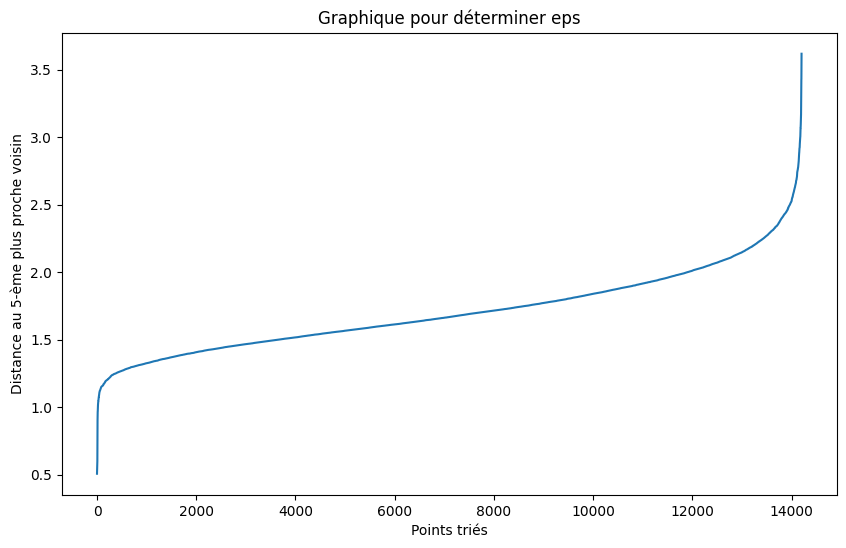

In [99]:
# Choisissez un min_samples raisonnable, par exemple 5
min_samples = 5

# Calcul des distances aux k plus proches voisins
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(features)
distances, indices = nbrs.kneighbors(features)

# Extraire les distances au k-ème voisin
k_distances = np.sort(distances[:, min_samples - 1])

# Trace du graphique des distances k-voisins
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.ylabel(f'Distance au {min_samples}-ème plus proche voisin')
plt.xlabel('Points triés')
plt.title('Graphique pour déterminer eps')
plt.show()


Les valeurs des distances k-voisins que vous avez trouvées (un premier coude à 1.3 et un second à 2.4) sont cruciales pour définir un bon paramètre eps pour DBSCAN. Voici comment analyser et utiliser ces informations pour votre clustering.

Interprétation du graphique des k-distances
Coude à 1.3 :

733 individus ont des distances inférieures à 1.3, ce qui signifie que ces observations sont relativement proches les unes des autres. Il s'agit donc probablement des points qui pourraient former des clusters denses.
Le fait que cette portion de la courbe devienne très rapidement oblique avant 1.3 indique que choisir un eps légèrement inférieur ou proche de 1.3 pourrait permettre de capturer ces observations dans des clusters denses.
Coude à 2.4 :

Les 400 individus avec des distances supérieures ou égales à 2.4 semblent être beaucoup plus dispersés, ce qui signifie qu'ils sont éloignés les uns des autres. Ils pourraient être considérés comme du bruit ou des outliers par DBSCAN.
La transition rapide après 2.4 indique que les distances augmentent fortement, ce qui suggère que ces points sont isolés et ne font pas partie de clusters denses.
Entre 1.3 et 2.4 :

La partie de la courbe entre 1.3 et 2.4 montre une augmentation progressive mais assez plate. Cela signifie que les points dans cette plage de distances ne sont pas aussi denses que ceux en dessous de 1.3, mais ne sont pas non plus des outliers aussi évidents que ceux au-dessus de 2.4.
Ils pourraient être des observations intermédiaires qui se connectent aux clusters plus denses ou être faiblement connectés aux points voisins.
Choix de eps
Premier coude à 1.3 : Cela semble être un bon choix pour le paramètre eps, car il capture une majorité d'observations denses tout en séparant celles qui sont plus dispersées.
Deuxième coude à 2.4 : Ce seuil est probablement trop élevé, car il commencerait à inclure des points dispersés et du bruit.
Suggestion : Testez eps autour de 1.3 en ajustant légèrement au besoin.

Tester toutes les valeurs entre 1.3 et 2.4

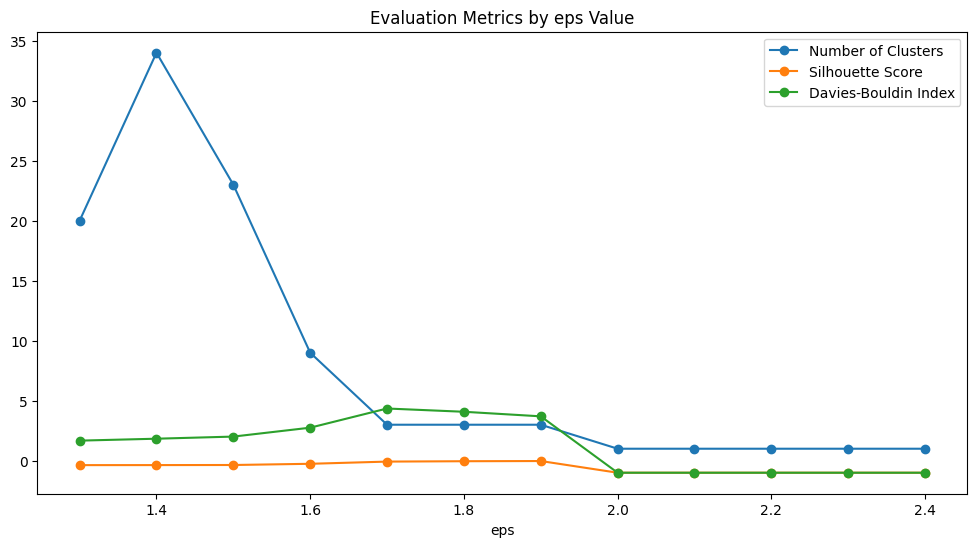

In [115]:
# Initialisation de la liste pour stocker les résultats
results = []

# Boucle sur les différentes valeurs de eps
for eps in [round(i, 1) for i in list(np.arange(1.3, 2.5, 0.1))]:
    # Appliquer DBSCAN avec la valeur de eps courante
    dbscan = DBSCAN(eps=eps, min_samples=10)
    dbscan_labels = dbscan.fit_predict(features)

    # Calcul du nombre de clusters (en excluant les outliers avec le label -1)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    
    # Évaluation des résultats seulement si au moins 2 clusters sont trouvés
    if n_clusters > 1:
        dbscan_silhouette = silhouette_score(features, dbscan_labels)
        dbscan_davies_bouldin = davies_bouldin_score(features, dbscan_labels)
    else:
        dbscan_silhouette = -1
        dbscan_davies_bouldin = -1
    n_outliers = list(dbscan_labels).count(-1)
    percentage_outliers = n_outliers / len(features)

    # Ajouter les résultats dans la liste
    results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'silhouette_score': dbscan_silhouette,
        'davies_bouldin_index': dbscan_davies_bouldin,
        'n_outliers' : n_outliers,
        'percentage_outliers' : percentage_outliers
    })

# Convertir la liste en dataframe
results_DBSCAN_eps = pd.DataFrame(results)

#Graphiques des scores 
plt.figure(figsize=(12, 6))
plt.plot(results_DBSCAN_eps['eps'], results_DBSCAN_eps['n_clusters'], label='Number of Clusters', marker='o')
plt.plot(results_DBSCAN_eps['eps'], results_DBSCAN_eps['silhouette_score'], label='Silhouette Score', marker='o')
plt.plot(results_DBSCAN_eps['eps'], results_DBSCAN_eps['davies_bouldin_index'], label='Davies-Bouldin Index', marker='o')

plt.xlabel('eps')
plt.legend()
plt.title('Evaluation Metrics by eps Value')
plt.show()


D'après les résultats de votre tableau, voici une analyse détaillée de chaque métrique et comment elle évolue en fonction de eps :

1. Nombre de clusters (n_clusters)
Le nombre de clusters commence à 20 pour eps = 1.3 et diminue progressivement à mesure que eps augmente. À partir de eps = 2.0, il ne reste plus qu'un seul cluster (aucun clustering effectif).
Cela suggère que des valeurs d'eps plus élevées entraînent une fusion progressive des clusters.
2. Score silhouette (silhouette_score)
Le score silhouette est négatif pour toutes les valeurs de eps, ce qui indique une mauvaise séparation des clusters, ou des clusters mal définis.
Le score se rapproche de 0 (ce qui est mieux, mais encore insuffisant) lorsque eps augmente autour de 1.7-1.9, mais il reste très bas, signalant des clusters mal formés.
Les valeurs de -1 pour eps ≥ 2.0 indiquent qu’il n’y a plus de structure de cluster (seulement des outliers).
3. Indice de Davies-Bouldin (davies_bouldin_index)
L'indice Davies-Bouldin est élevé, surtout pour eps ≥ 1.7, ce qui confirme la mauvaise séparation des clusters.
Des valeurs faibles de Davies-Bouldin sont meilleures. Ici, l'augmentation de cet indice montre que les clusters deviennent de moins en moins définis au fur et à mesure que eps augmente.
4. Nombre d'outliers (n_outliers)
Le nombre d'outliers diminue à mesure que eps augmente, comme prévu, car des valeurs plus élevées d'eps englobent davantage de points dans les clusters.
Toutefois, pour les faibles valeurs de eps (par exemple, 1.3 et 1.4), presque toutes les observations sont considérées comme des outliers, ce qui n'est pas souhaitable.
5. Pourcentage d'outliers (percentage_outliers)
Le pourcentage d'outliers est très élevé pour eps = 1.3 et eps = 1.4 (98% et 91%, respectivement), mais diminue fortement avec l'augmentation de eps. Cela reflète que beaucoup de points sont isolés lorsque eps est petit.
Conclusion de cette analyse :
eps entre 1.7 et 1.9 semble être une zone potentiellement intéressante, car c’est là où le score silhouette est le moins négatif et où le nombre d'outliers est réduit.
Toutefois, même dans cette plage, le score silhouette est encore faible et l'indice de Davies-Bouldin est très élevé, signalant que les clusters ne sont pas bien définis. Cela pourrait indiquer que DBSCAN n'est peut-être pas la meilleure méthode pour votre jeu de données.
Plan d'action proposé :
DBSCAN :

Essayez de tester d'autres valeurs de eps proches de 1.7 à 1.9, tout en ajustant min_samples pour voir si la définition des clusters peut être améliorée.
Si les résultats ne s'améliorent pas, considérez que DBSCAN pourrait ne pas être le meilleur algorithme pour votre problématique.

In [118]:
# Plage d'eps étendue et pas plus petit
eps_values = [x / 10.0 for x in range(5, 40)]  # De 0.5 à 2.4
min_samples_range = range(1, 900, 10)  # Tester min_samples de 1 à 100

# Réinitialiser les résultats
results = []

# Boucle pour tester chaque valeur de eps
for eps in eps_values:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(features)

        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        dbscan_silhouette = silhouette_score(features, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
        dbscan_davies_bouldin = davies_bouldin_score(features, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
        
        n_outliers = (dbscan_labels == -1).sum()
        percentage_outliers = n_outliers / len(features)

        results.append([eps, min_samples, n_clusters, dbscan_silhouette, dbscan_davies_bouldin, n_outliers, percentage_outliers])

# Créer un DataFrame à partir des résultats
results_dbscan_min_sample = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'silhouette_score', 'davies_bouldin_index', 'n_outliers', 'percentage_outliers'])


Le code que j'ai utilisé m'a permis de générer 3150 combinaisons d'eps et de min_samples pour le modèle DBSCAN. J'ai appliqué un premier filtrage en éliminant les combinaisons qui généraient un nombre de clusters supérieur à 1000 ou inférieur ou égal à 1, un pourcentage d'outliers supérieur à 70 %, et un silhouette_score supérieur ou égal à 0. Après ce filtrage initial, seules 8 configurations restaient.

Une analyse plus approfondie de ces configurations a révélé plusieurs problèmes :

Sur-segmentation : 7 des 8 configurations créaient des clusters contenant un seul individu, ce qui reflète un problème de sur-segmentation ou de sur-ajustement du modèle. De plus, ces configurations n'identifiaient aucun outlier, ce qui suggère que tous les points sont forcés dans des clusters sans qu'il y ait une distinction claire des points aberrants.
Mauvaise séparation des clusters : La dernière configuration restante (avec 2 clusters) présentait un silhouette_score et un indice de Davies-Bouldin indiquant une mauvaise qualité de séparation des clusters. Cela montre que DBSCAN échoue à identifier des groupes distincts de manière cohérente dans mes données.
En conclusion, DBSCAN n'est pas bien adapté à la structure de mes données. Le modèle produit soit des clusters trop petits et mal définis, soit une sur-segmentation sans distinction d'outliers. Je vais donc me tourner vers des modèles plus flexibles comme GMM (Gaussian Mixture Model), qui pourrait mieux capturer la structure sous-jacente de mes données grâce à sa capacité à modéliser des clusters plus complexes et des probabilités d'appartenance.

dbscan2 = DBSCAN(eps=1.9, min_samples=11)  # Ajustez eps et min_samples selon vos besoins
dbscan_labels2 = dbscan2.fit_predict(features)

# Nombre de clusters trouvés (en excluant les outliers avec le label -1)
n_clusters2 = len(set(dbscan_labels2)) - (1 if -1 in dbscan_labels2 else 0)

# Évaluation des résultats
dbscan_silhouette2 = silhouette_score(features, dbscan_labels2) if len(set(dbscan_labels2)) > 1 else -1
dbscan_davies_bouldin2 = davies_bouldin_score(features, dbscan_labels2) if len(set(dbscan_labels2)) > 1 else -1


print(f'Nombre de clusters trouvés : {n_clusters2}, DBSCAN - Silhouette Score: {dbscan_silhouette2}, Davies-Bouldin Index: {dbscan_davies_bouldin2}')


pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(12, 8))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels2, cmap='viridis', label='DBSCAN Clusters')
plt.title('DBSCAN Clusters Visualized in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

## Gaussian Mixture Model (GMM)

In [128]:

# Plage de clusters à tester
n_clusters_range = range(2, 300)

# Initialisation des listes pour stocker les résultats
bic_scores = []
silhouette_scores = []
davies_bouldin_scores = []
best_gmm_model = None
lowest_bic = np.inf  # Pour stocker le modèle avec le plus bas BIC

# Boucle sur différents nombres de clusters
for n_clusters in n_clusters_range:
    # Initialisation et ajustement du modèle GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(features)
    
    # Calcul du BIC
    bic = gmm.bic(features)
    bic_scores.append(bic)
    
    # Vérification si c'est le meilleur modèle (le plus bas BIC)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm_model = gmm
    
    # Calcul du silhouette score (si plus d'un cluster)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(features, gmm_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(np.nan)  # Non applicable pour 1 cluster
    
    # Calcul de l'indice de Davies-Bouldin
    if n_clusters > 1:
        db_score = davies_bouldin_score(features, gmm_labels)
        davies_bouldin_scores.append(db_score)
    else:
        davies_bouldin_scores.append(np.nan)  # Non applicable pour 1 cluster
    print(n_clusters, bic, silhouette_avg, db_score)



2 457176.3770066562 0.09497947431365661 2.908114818424073
3 389054.6108744291 0.05142275395529646 3.3778900919421084
4 386597.657839216 0.022633775528819032 3.6630882140116534
5 382831.19877604983 0.043707685730245395 3.4450916863105356
6 382933.27629688586 -0.008725291652321337 4.016766531089872
7 382435.9475563483 -0.0025750801641681296 3.6395598925530703
8 380264.36020199285 -0.012887346676603649 3.6508652482170816
9 378451.3824570266 -0.006337707052036978 3.314600879500884
10 361508.61613110645 -0.04317053704233909 3.5078400798068676
11 253959.73726817465 -0.02605393392638045 3.956104796310551
12 194083.49349559387 -0.04131938619807158 4.4346713283723
13 271002.6053311027 -0.021539523083547264 4.208441991574917
14 372798.5984660424 -0.04931232446111248 2.8729189611409365
15 298087.85369283386 -0.042478888018755864 3.7762695854946546
16 231199.32853687846 -0.022490851309068673 4.522750918023125
17 247247.80007229737 -0.05180716338807165 3.9345360964596496
18 223823.4353918298 -0.037

KeyboardInterrupt: 

In [130]:
n_clusters_range2 = range(2, 173)

# Création d'un DataFrame pour visualiser les résultats
results_gmm_model = pd.DataFrame({
    'n_clusters': n_clusters_range2,
    'BIC': bic_scores,
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Index': davies_bouldin_scores
})

# Afficher les résultats
#print(results_df)

# Meilleur modèle basé sur le BIC
print(f"The best GMM model has {best_gmm_model.n_components} clusters with a BIC of {lowest_bic}.")


The best GMM model has 80 clusters with a BIC of 30277.469039155083.


L'analyse des résultats fournis pour le modèle GMM sur 2 à 172 clusters révèle plusieurs points importants. Voici une explication des résultats basés sur les trois métriques clés : BIC, Silhouette Score, et Davies-Bouldin Index.

1. BIC (Bayesian Information Criterion) :
Le BIC diminue au fur et à mesure que le nombre de clusters augmente. Cela suggère que le modèle avec plus de clusters est toujours préféré en termes de complexité et d'ajustement, ce qui est attendu pour un critère d'information comme le BIC.
Le BIC atteint des valeurs très faibles avec un nombre de clusters élevé, comme par exemple avec 80 clusters (BIC ≈ 30277), 50 clusters (BIC ≈ 42798) et 39 clusters (BIC ≈ 68911).
Cependant, il est important de noter qu'un BIC plus bas n'est pas toujours un indicateur que le modèle est meilleur, surtout si la segmentation devient trop complexe (sursegmentation) sans fournir de réelle valeur.
2. Silhouette Score :
Le score de silhouette est une métrique qui mesure à quel point les points au sein d'un cluster sont similaires et à quel point ils sont bien séparés des autres clusters. Des valeurs proches de 1 indiquent une bonne séparation, tandis que des valeurs proches de -1 indiquent des regroupements incorrects ou un chevauchement entre clusters.
Les résultats montrent que tous les scores de silhouette sont très faibles et deviennent négatifs dès le passage à 6 clusters. Le score atteint environ -0.20 pour 172 clusters, ce qui indique une très mauvaise séparation des clusters.
Cela indique que, malgré l'amélioration du BIC, la qualité des clusters en termes de séparation ne s'améliore pas, et même se dégrade.
3. Davies-Bouldin Index :
L'indice de Davies-Bouldin mesure la compacité des clusters et leur séparation. Des valeurs faibles indiquent des clusters compacts et bien séparés.
Les valeurs observées pour le Davies-Bouldin sont relativement élevées, dépassant souvent 3.0, ce qui n'est pas favorable. Un bon modèle devrait avoir un indice bien plus bas (proche de 1 ou 2).
Dans l'ensemble, même si le BIC s'améliore avec l'augmentation des clusters, l'indice de Davies-Bouldin montre que la qualité des clusters ne s'améliore pas, avec une séparation insuffisante entre les groupes.
Conclusion :
BIC : Bien que le BIC continue de diminuer avec l'ajout de clusters, cela peut être un signe de sursegmentation. Un nombre excessif de clusters (par exemple, 80, 100 ou plus) peut donner un BIC faible, mais cela ne signifie pas que ces clusters sont significatifs d'un point de vue pratique ou interprétable.

Silhouette Score : Les scores de silhouette sont faibles et deviennent négatifs dès que le nombre de clusters dépasse 6. Cela indique que le modèle peine à former des clusters bien distincts et que la plupart des clusters se chevauchent ou sont mal définis.

Davies-Bouldin Index : Les valeurs élevées de l'indice indiquent également une mauvaise séparation des clusters et un manque de compacité.

Recommandation :

Le modèle GMM semble ne pas convenir parfaitement à vos données en raison de la faiblesse des scores de silhouette et de l'indice de Davies-Bouldin. Même si le BIC continue de baisser avec l'ajout de clusters, la qualité des clusters ne s'améliore pas.
Il pourrait être utile d'explorer d'autres modèles ou approches de clustering, comme le K-Means avec une analyse plus approfondie de l'inertie, ou même revenir à des méthodes comme DBSCAN, en ajustant les hyperparamètres avec prudence.
En conclusion, le modèle GMM sur ces données, malgré des BIC encourageants, n'apporte pas de séparation claire ou significative des clusters, et une autre approche de clustering pourrait s'avérer plus adaptée.

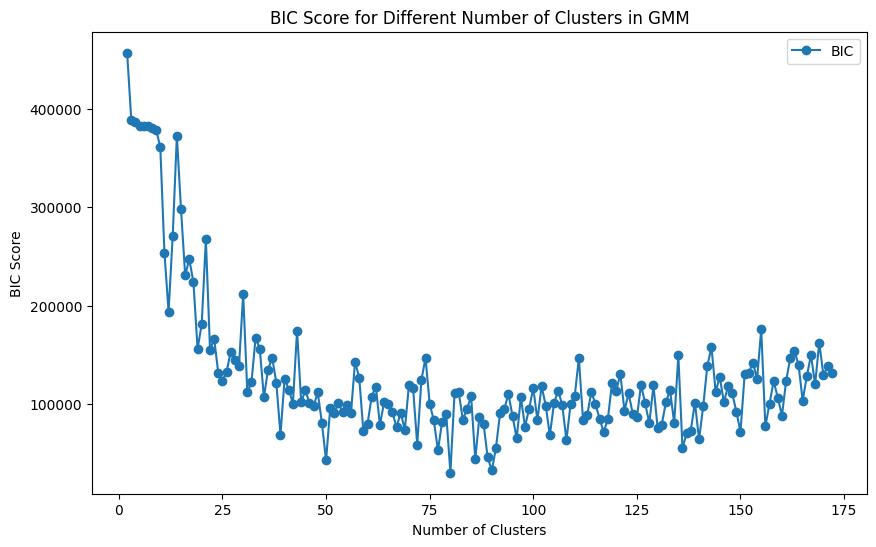

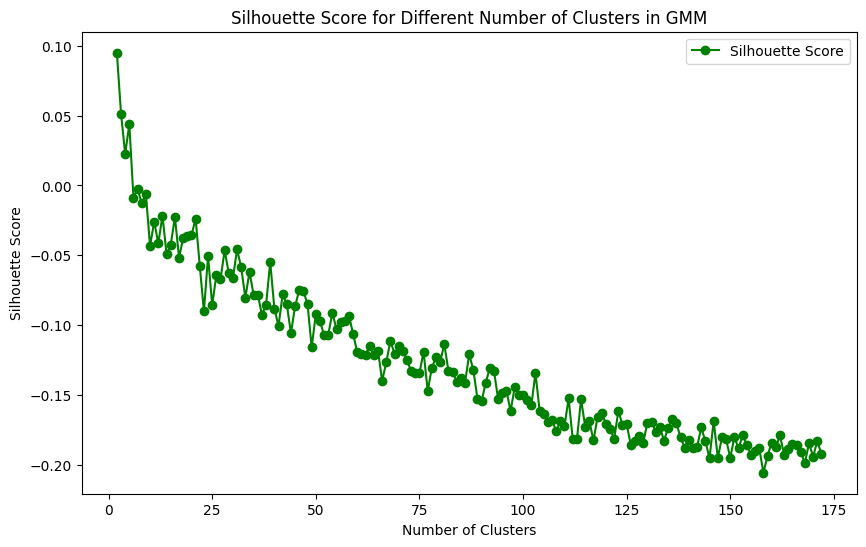

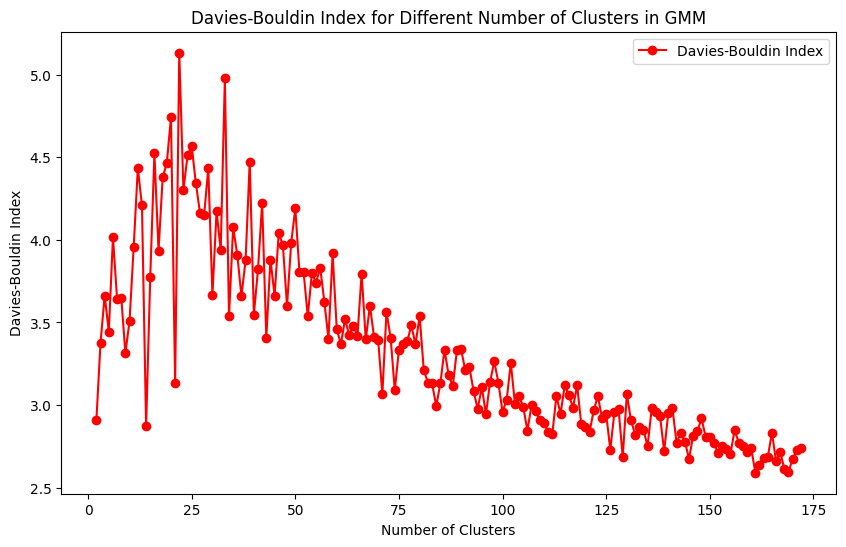

In [132]:

# Tracer le BIC pour visualiser le meilleur modèle
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range2, bic_scores, label='BIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.title('BIC Score for Different Number of Clusters in GMM')
plt.legend()
plt.show()

# Tracer le Silhouette Score pour vérifier la qualité de la séparation
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range2, silhouette_scores, label='Silhouette Score', marker='o', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters in GMM')
plt.legend()
plt.show()

# Tracer le Davies-Bouldin Index pour vérifier la compacité
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range2, davies_bouldin_scores, label='Davies-Bouldin Index', marker='o', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different Number of Clusters in GMM')
plt.legend()
plt.show()


gmm = GaussianMixture(n_components=5, random_state=0)  # Ajustez n_components selon vos besoins
gmm_labels = gmm.fit_predict(features)

# Évaluation des résultats
gmm_silhouette = silhouette_score(features, gmm_labels)
gmm_davies_bouldin = davies_bouldin_score(features, gmm_labels)

print(f'GMM - Silhouette Score: {gmm_silhouette}, Davies-Bouldin Index: {gmm_davies_bouldin}')


plt.figure(figsize=(12, 8))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=gmm_labels, cmap='plasma', label='GMM Clusters')
plt.title('GMM Clusters Visualized in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

Plan d'action proposé :
Normaliser et standardiser les données si ce n’est pas déjà fait.
Essayer classification hiérarchique 
Essayer k-means si CH  est trop coûteux en calcul (ou ne donne pas de bons résultats),avec plusieurs valeurs de K (par exemple 2 à 30) et appliquer la méthode du coude pour identifier le nombre optimal de clusters.
Tester des approches plus flexibles comme HDBSCAN et OPTICS.
Visualiser les données avec PCA ou t-SNE pour vérifier s'il y a une structure visuelle qui échappe aux algorithmes.
Si le clustering reste inefficace, explorer d'autres méthodes (supervisées ou de réduction de dimension).

## Clustering Hiérarchique

### Méthode ward

In [ ]:
# Déterminer le nombre de clusters optimal avec le score de silhouette
silhouette_scores_w = []
range_n_clusters_w = list(range(2, 100))  # Tester de 2 à 10 clusters (ajuster en fonction de ton besoin)

for n_clusters in range_n_clusters_w:
    clusterer_w = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels_w = clusterer_w.fit_predict(features)
    silhouette_avg_w = silhouette_score(features, cluster_labels_w)
    silhouette_scores_w.append(silhouette_avg_w)

# Tracer le score de silhouette pour chaque nombre de clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters_w, silhouette_scores_w, marker='o')
plt.title("Méthode du coude avec le score de silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette moyen")
plt.show()


In [ ]:
# Générer la matrice de linkage (méthode de Ward)
Z_ward = linkage(features, method='ward')

# Visualiser le dendrogramme
plt.figure(figsize=(10, 7))
dendrogram(Z_ward)
plt.title('Dendrogram - Méthode de Ward')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.show()
# Appliquer la classification hiérarchique agglomérative (Méthode de Ward)
# Choisir un nombre de clusters, ici par exemple 5 clusters
model_ward = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
labels_ward = model_ward.fit_predict(features)

# Afficher les labels des clusters pour chaque individu
print("Labels des clusters (méthode de Ward) : ", labels_ward)


### CHA avec lien moyen

In [ ]:
# Déterminer le nombre de clusters optimal avec le score de silhouette
silhouette_scores_lm = []
range_n_clusters_lm = list(range(2, 100))  # Tester de 2 à 10 clusters (ajuster en fonction de ton besoin)

for n_clusters in range_n_clusters_lm:
    clusterer_lm = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='average')
    cluster_labels_lm = clusterer_lm.fit_predict(features)
    silhouette_avg_lm = silhouette_score(features, cluster_labels_lm)
    silhouette_scores_lm.append(silhouette_avg_lm)

# Tracer le score de silhouette pour chaque nombre de clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters_lm, silhouette_scores_lm, marker='o')
plt.title("Méthode du coude avec le score de silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette moyen")
plt.show()


In [ ]:

# Étape 1 : Générer la matrice de linkage (lien moyen)
Z_average = linkage(features, method='average')

# Étape 2 : Visualiser le dendrogramme pour la méthode du lien moyen
plt.figure(figsize=(10, 7))
dendrogram(Z_average)
plt.title('Dendrogram - Lien moyen')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.show()

# Étape 3 : Appliquer la classification hiérarchique agglomérative (Lien moyen)
# Choisir un nombre de clusters, ici par exemple 5 clusters
model_average = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='average')
labels_average = model_average.fit_predict(features)

# Afficher les labels des clusters pour chaque individu
print("Labels des clusters (lien moyen) : ", labels_average)


linked = linkage(features, 'method=')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=data['id'].values, distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Song ID')
plt.ylabel('Distance')
plt.show()

# Évaluation des clusters hiérarchiques
# En extraire des clusters (par exemple, 5 clusters)
from scipy.cluster.hierarchy import fcluster
hierarchical_labels = fcluster(linked, 5, criterion='maxclust')

hierarchical_silhouette = silhouette_score(features, hierarchical_labels)
hierarchical_davies_bouldin = davies_bouldin_score(features, hierarchical_labels)

print(f'Hierarchical Clustering - Silhouette Score: {hierarchical_silhouette}, Davies-Bouldin Index: {hierarchical_davies_bouldin}')
